### 0. Import Libraries

In [ ]:
!pip install datasets

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/emotions_dataset/'

test_df = pd.read_csv(path + 'test.csv', encoding='ISO-8859-1')
train_df = pd.read_csv(path + 'train.csv', encoding='ISO-8859-1')

### 1. Load the dataset

In [6]:
train_df = train_df[['text', 'sentiment']].dropna()
test_df = test_df[['text', 'sentiment']].dropna()

# Convert text to string (in case it's float or something else)
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

### 2. Encode labels to integers

In [ ]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}
train_df['label'] = train_df['sentiment'].map(label2id)
test_df['label'] = test_df['sentiment'].map(label2id)

In [7]:
train_df

text sentiment  label
0                    I`d have responded, if I were going   neutral      1
1          Sooo SAD I will miss you here in San Diego!!!  negative      0
2                              my boss is bullying me...  negative      0
3                         what interview! leave me alone  negative      0
4       Sons of ****, why couldn`t they put them on t...  negative      0
...                                                  ...       ...    ...
27476   wish we could come see u on Denver  husband l...  negative      0
27477   I`ve wondered about rake to.  The client has ...  negative      0
27478   Yay good for both of you. Enjoy the break - y...  positive      2
27479                         But it was worth it  ****.  positive      2
27480     All this flirting going on - The ATG smiles...   neutral      1

[27480 rows x 3 columns]

In [8]:
len(train_df), len(test_df)

(27480, 3534)

### 3. Convert to Hugging Face datasets

In [9]:
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})

In [10]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 27480
})

In [11]:
test_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3534
})

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 27480
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3534
    })
})

In [13]:
print(type(dataset['train'][0]['text']))
print(dataset['train'][0]['text'])
print(dataset['train'][:2]['text'])

<class 'str'>
 I`d have responded, if I were going
[' I`d have responded, if I were going', ' Sooo SAD I will miss you here in San Diego!!!']


In [14]:
import warnings
warnings.filterwarnings("ignore")

### 4. Load tokenizer

In [15]:
checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
  texts = [str(t) for t in batch["text"]]
  return tokenizer(texts, padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [17]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27480
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3534
    })
})

### 5. Load model

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 6. Training arguments

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    logging_dir="./logs"
)

### 7. Metrics function

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return classification_report(labels, preds, target_names=id2label.values(), output_dict=True)

### 8. Trainer

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Trainer is attempting to log a value of "{'precision': 0.8539192399049881, 'recall': 0.7182817182817183, 'f1-score': 0.7802495930548019, 'support': 1001.0}" of type <class 'dict'> for key "eval/negative" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7205793602896802, 'recall': 0.8349650349650349, 'f1-score': 0.7735665694849369, 'support': 1430.0}" of type <class 'dict'> for key "eval/neutral" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8618357487922705, 'recall': 0.8087035358114234, 'f1-score': 0.8344246959775491, 'support': 1103.0}" of type <class 'dict'> for key "eval/positive" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.81211

TrainOutput(global_step=1290, training_loss=0.385979934810668, metrics={'train_runtime': 1369.1055, 'train_samples_per_second': 60.214, 'train_steps_per_second': 0.942, 'total_flos': 4594182275477088.0, 'train_loss': 0.385979934810668, 'epoch': 3.0})

### 9. Evaluate

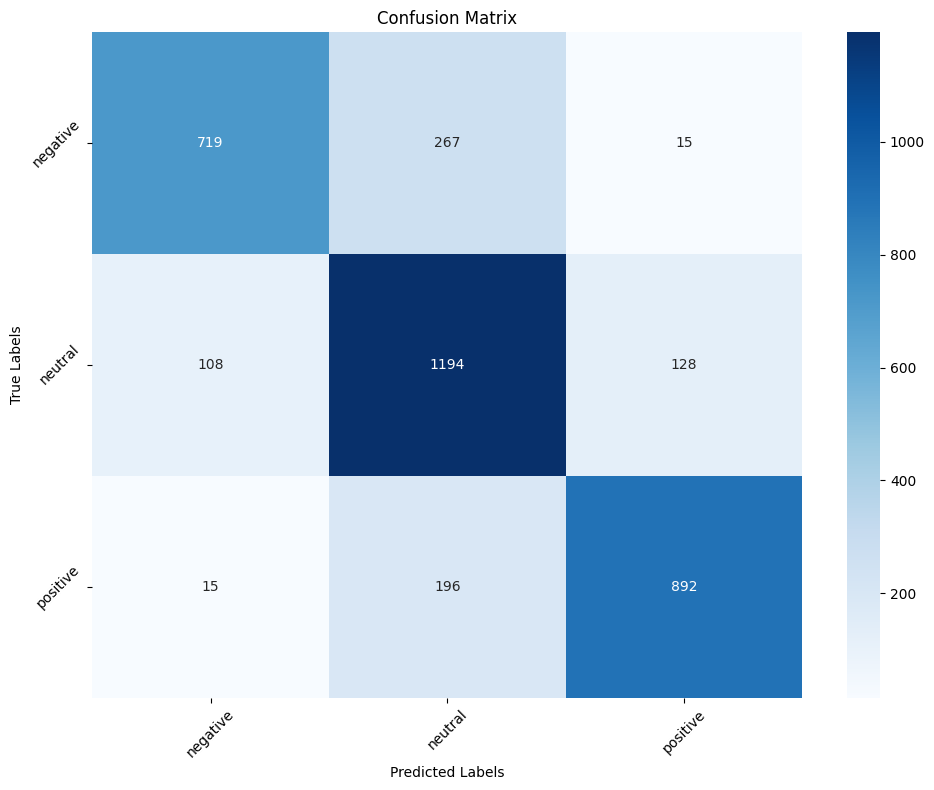

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(id2label.values())

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
from tabulate import tabulate

# Print overall stats
print("📌 General Evaluation Metrics:")
print(f"  🔹 Loss: {eval_results['eval_loss']:.4f}")
print(f"  🔹 Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"  ⏱️ Runtime: {eval_results['eval_runtime']:.2f}s | Samples/sec: {eval_results['eval_samples_per_second']:.2f}")

# Print class-wise metrics
print("\n📈 Per-Class Metrics:")
rows = []
for label in ['eval_negative', 'eval_neutral', 'eval_positive']:
    metrics = eval_results[label]
    rows.append([
        label.replace("eval_", "").capitalize(),
        f"{metrics['precision']:.4f}",
        f"{metrics['recall']:.4f}",
        f"{metrics['f1-score']:.4f}",
        int(metrics['support'])
    ])

print(tabulate(rows, headers=["Label", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))

# Print macro & weighted avg
print("\n📊 Averages:")
macro = eval_results['eval_macro avg']
weighted = eval_results['eval_weighted avg']

print(tabulate([
    ["Macro Avg", f"{macro['precision']:.4f}", f"{macro['recall']:.4f}", f"{macro['f1-score']:.4f}"],
    ["Weighted Avg", f"{weighted['precision']:.4f}", f"{weighted['recall']:.4f}", f"{weighted['f1-score']:.4f}"],
], headers=["Type", "Precision", "Recall", "F1-Score"], tablefmt="fancy_grid"))


📌 General Evaluation Metrics:
  🔹 Loss: 0.4963
  🔹 Accuracy: 0.7937
  ⏱️ Runtime: 10.83s | Samples/sec: 326.21

📈 Per-Class Metrics:
╒══════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label    │   Precision │   Recall │   F1-Score │   Support │
╞══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Negative │      0.8539 │   0.7183 │     0.7802 │      1001 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ Neutral  │      0.7206 │   0.835  │     0.7736 │      1430 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ Positive │      0.8618 │   0.8087 │     0.8344 │      1103 │
╘══════════╧═════════════╧══════════╧════════════╧═══════════╛

📊 Averages:
╒══════════════╤═════════════╤══════════╤════════════╕
│ Type         │   Precision │   Recall │   F1-Score │
╞══════════════╪═════════════╪══════════╪════════════╡
│ Macro Avg    │      0.8121 │   0.7873 │     0.7961 │
├──────────────┼─────────────┼──────────┼────────────┤
│ Weighted A